In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Load the titanic dataset and display the first few rows of the DataFrame to understand its structure.

In [ ]:
df=pd.read_excel('titanic3.xlsx')

In [ ]:
print(df.head())


   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

2. For the above dataset use Missingno library to visualize the following

  msno.bar(data);
  msno.matrix(data)


<Axes: >

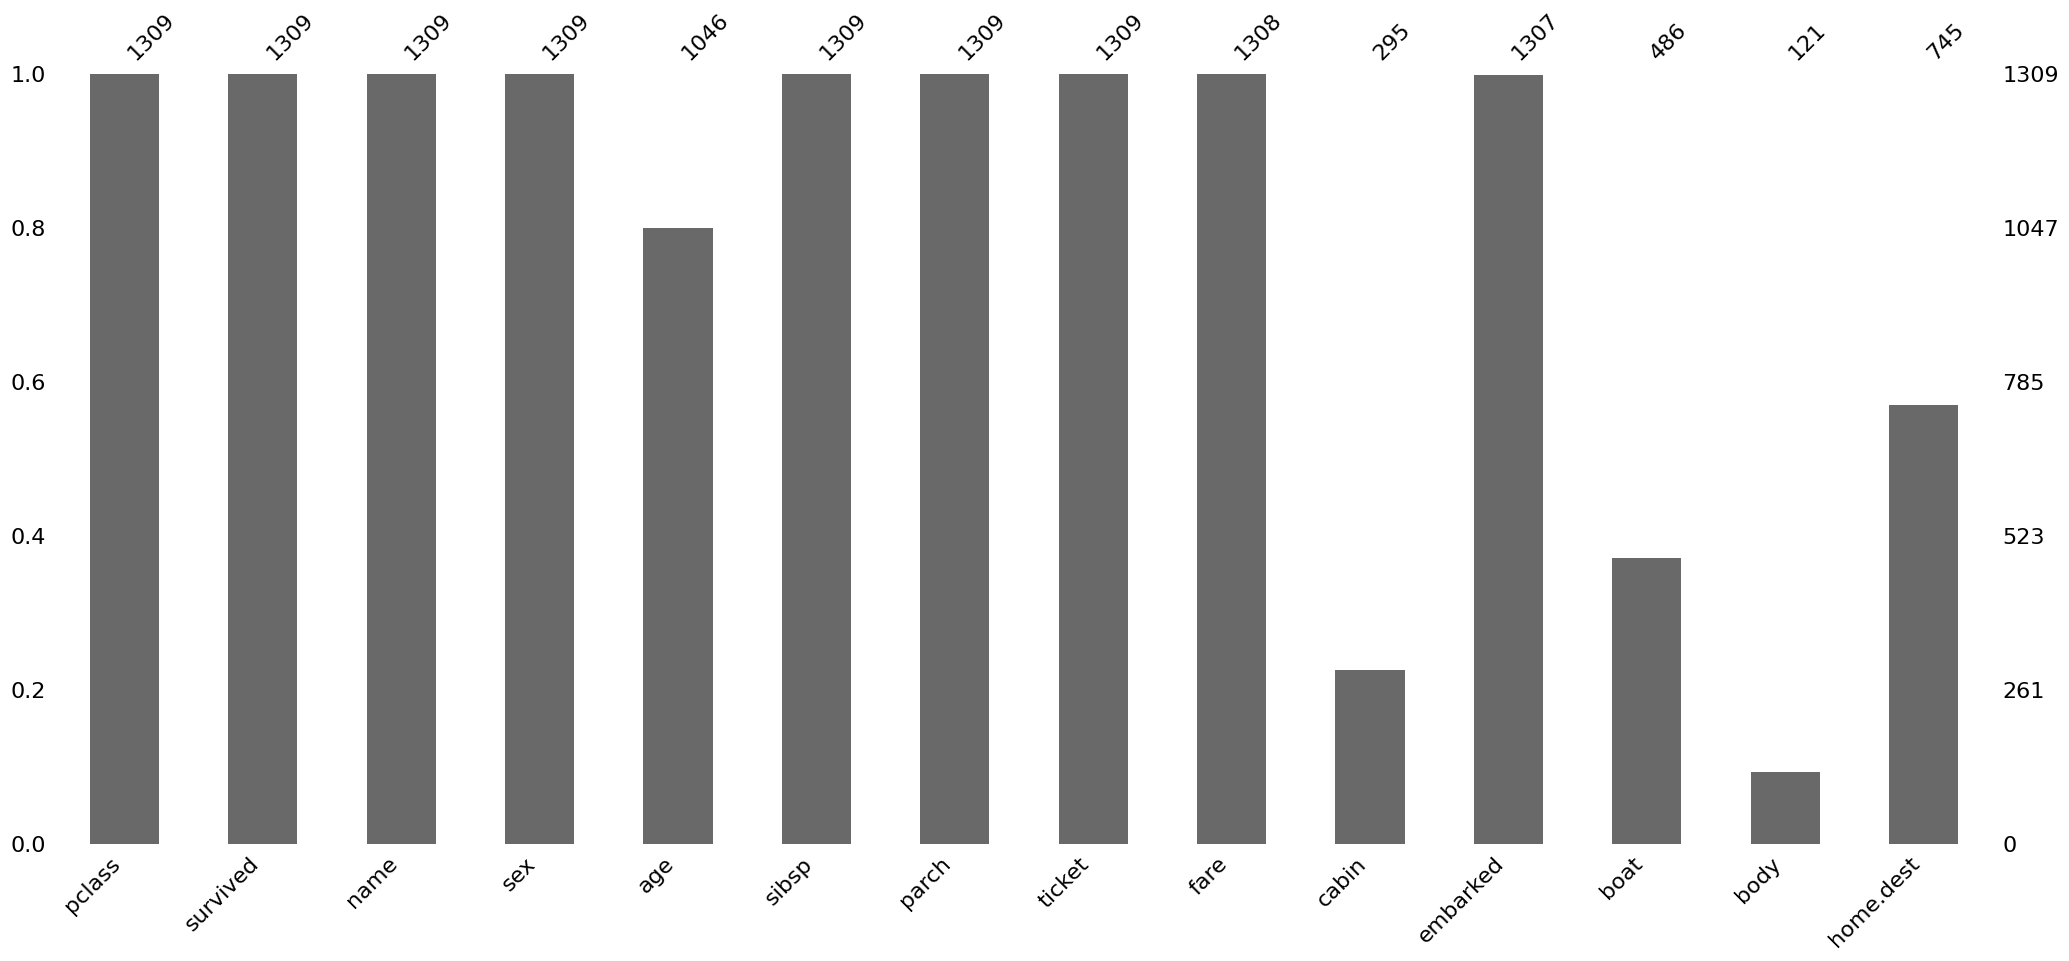

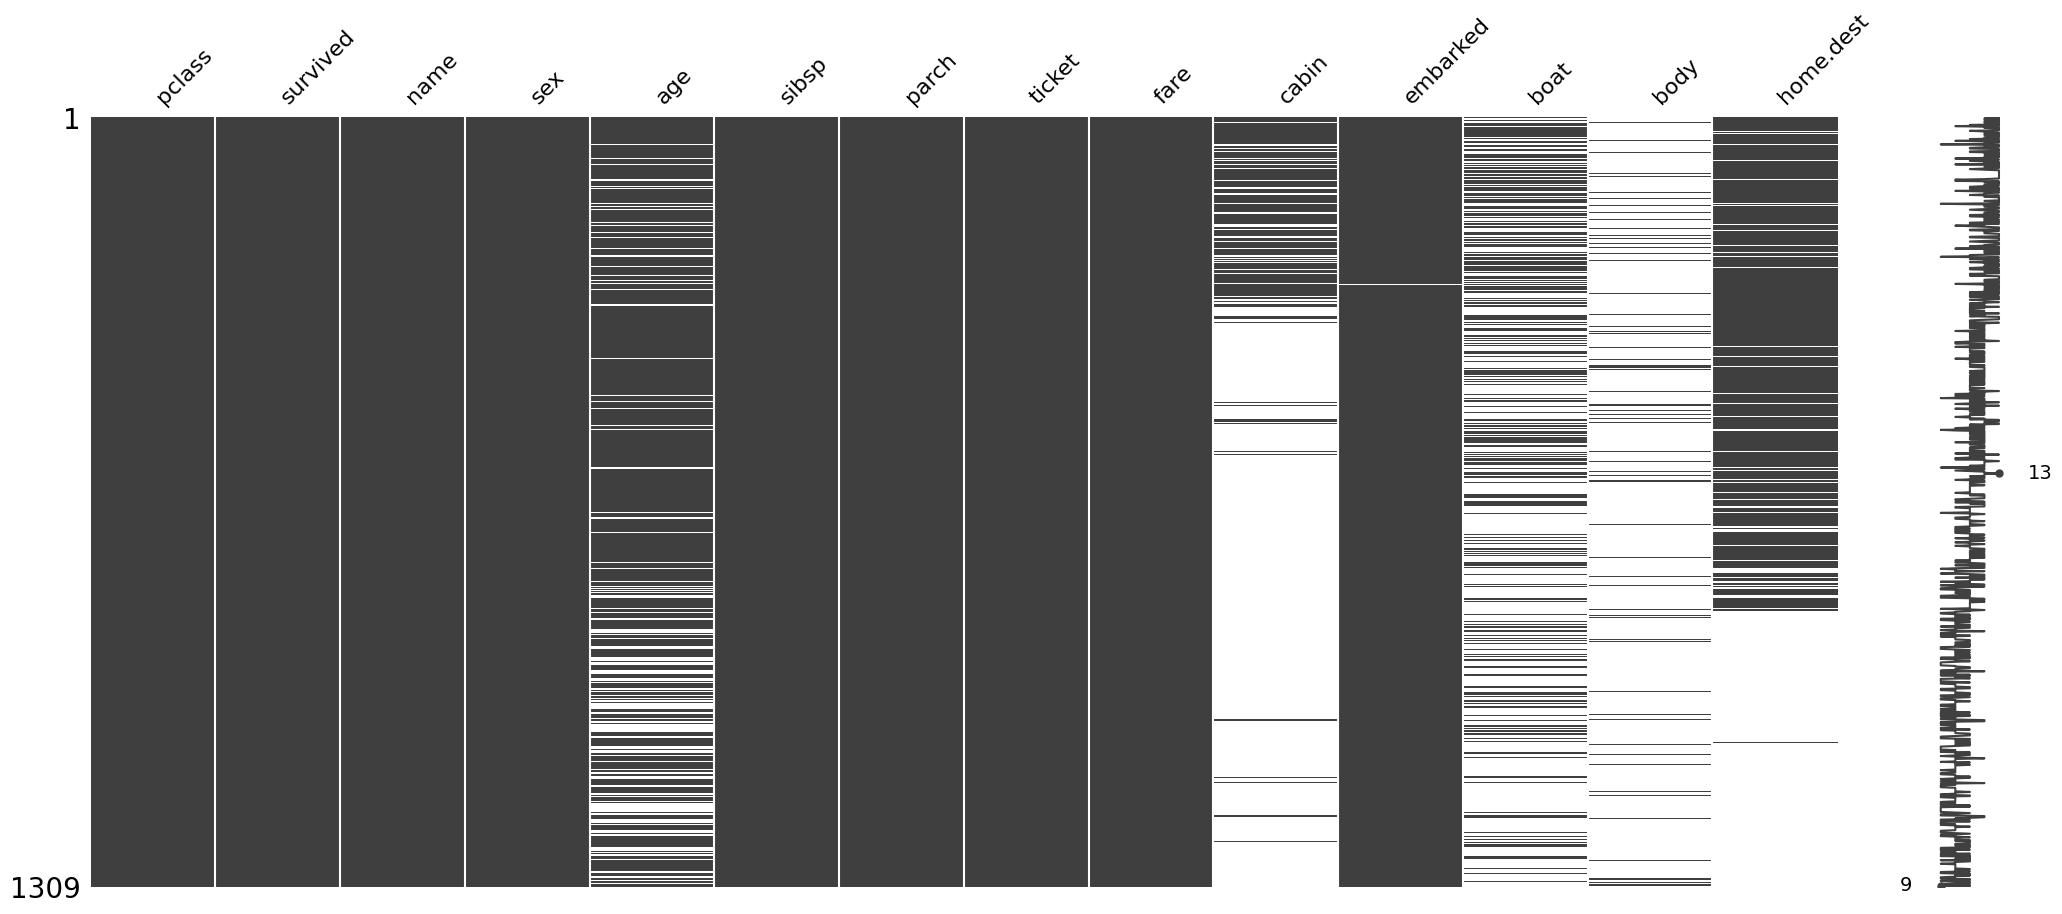

In [ ]:
msno.bar(df)
msno.matrix(df)

3. Drop rows which contain any Nan or missing value in ‘fare’ column.

In [ ]:
df = df.dropna(subset=['fare'])

print(df.head())

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

4. Replace the ‘pclass’ and ‘cabin’ the most frequent value.

In [ ]:
df['pclass'] = df['pclass'].fillna(df['pclass'].mode()[0])

df['cabin'] = df['cabin'].fillna(df['cabin'].mode()[0])

5. Replace the missing value in column ‘sibsp’ with ffill.

In [ ]:
df['sibsp'] = df['sibsp'].ffill()

print(df.head())

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

6. Make use of the above KNNimputer to impute missing values in ‘body’ column.



In [ ]:
from sklearn.impute import KNNImputer

# Select columns to use for KNN Imputation
knn_data = df[['body', 'age', 'fare', 'sibsp', 'parch']]

# Create the KNN Imputer with n_neighbors=5 (you can adjust as needed)
imputer = KNNImputer(n_neighbors=5)

# Apply the imputer
knn_imputed = imputer.fit_transform(knn_data)

# Convert the result back to DataFrame and update the original 'body' column
df['body'] = knn_imputed[:, 0]

# Print the first few rows to verify the imputation
print(df[['body', 'age', 'fare', 'sibsp', 'parch']].head())


    body      age      fare  sibsp  parch
0  109.4  29.0000  211.3375      0      0
1  124.2   0.9167  151.5500      1      2
2  124.2   2.0000  151.5500      1      2
3  135.0  30.0000  151.5500      1      2
4  139.6  25.0000  151.5500      1      2


7. Identify the variables which can be used for regression imputation on the column ‘age.’

In [ ]:
# Select only numerical columns for correlation analysis
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Check correlation of 'age' with other numerical variables
correlation = numeric_df.corr()
age_correlation = correlation['age'].sort_values(ascending=False)
print(age_correlation)


age         1.000000
fare        0.178739
body        0.116497
survived   -0.053958
parch      -0.150241
sibsp      -0.243139
pclass     -0.411086
Name: age, dtype: float64


8. Impute the values in the ‘survived’ column using the columns identified in 7 using regression imputation

In [ ]:
from sklearn.linear_model import LinearRegression

# Step 1: Identify predictor variables from the correlation analysis for 'age'
# Let's assume the identified predictors are: 'age', 'fare', 'pclass', 'sibsp'
predictors = ['age', 'fare', 'pclass', 'sibsp']

# Step 2: Prepare training data (only rows where 'survived' is not missing)
train_data = df.dropna(subset=['survived'])
X_train = train_data[predictors]
y_train = train_data['survived']

# Step 3: Prepare data for prediction (rows where 'survived' is missing)
missing_survived = df[df['survived'].isnull()]
X_missing = missing_survived[predictors]

# Check if there are rows with missing 'survived' values to proceed
if not missing_survived.empty:
    # Step 4: Train the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Step 5: Predict the missing values in 'survived'
    predicted_survived = model.predict(X_missing)

    # Step 6: Update the original DataFrame with the predicted values
    df.loc[df['survived'].isnull(), 'survived'] = predicted_survived

    # Verify the imputed 'survived' column
    print(df['survived'].head(10))
else:
    print("No missing values in the 'survived' column.")


No missing values in the 'survived' column.


9. By making use of multivariate feature imputation impute the missing values in the column ‘age’.




In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Create a deep copy of the original DataFrame to avoid modifying it
train_mice = df.copy(deep=True)

# Create an instance of IterativeImputer
mice_imputer = IterativeImputer()

# Apply the imputer to the entire DataFrame considering relevant features
# Ensure 'age' is included along with other features for better imputation
train_mice[['age', 'body', 'fare', 'sibsp', 'parch']] = mice_imputer.fit_transform(
    train_mice[['age', 'body', 'fare', 'sibsp', 'parch']]
)

# Update the original DataFrame with imputed values for 'age'
df['age'] = train_mice['age']

# Optionally, check how many missing values are left in 'age'
print("Missing values in 'age' after imputation:", df['age'].isnull().sum())

# Print the first few rows to verify the imputation
print(df[['age', 'body', 'fare', 'sibsp', 'parch']].head())


Missing values in 'age' after imputation: 0
       age   body      fare  sibsp  parch
0  29.0000  109.4  211.3375      0      0
1   0.9167  124.2  151.5500      1      2
2   2.0000  124.2  151.5500      1      2
3  30.0000  135.0  151.5500      1      2
4  25.0000  139.6  151.5500      1      2


___________________________
**Exercise II Noise Removal**
-----
---



1. Load the dataset iris.csv from the url “archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data”

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"


2. Attach the headers ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"] to the dataset.

In [ ]:
headers = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]
df = pd.read_csv(url, header=None, names=headers)

# Display the first few rows of the dataset
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


3. For the column ‘sepal_length’ perform binning by distance with number of bins as 3.

In [ ]:
import numpy as np

# Perform binning by distance
bin_edges = np.linspace(df['sepal_length'].min(), df['sepal_length'].max(), num=4)  # 3 bins -> 4 edges
df['distance_binned'] = pd.cut(df['sepal_length'], bins=bin_edges, include_lowest=True)
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species,distance_binned
0,5.1,3.5,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]"
1,4.9,3.0,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]"
2,4.7,3.2,1.3,0.2,Iris-setosa,"(4.2989999999999995, 5.5]"
3,4.6,3.1,1.5,0.2,Iris-setosa,"(4.2989999999999995, 5.5]"
4,5.0,3.6,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]"


4. Plot the distribution of values, by using the hist() function of the matplotlib package.



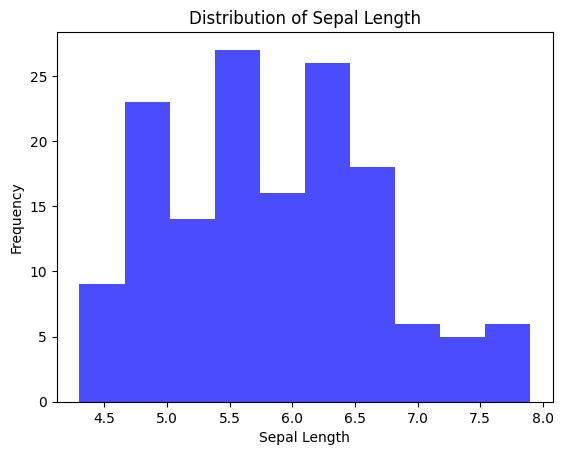

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(df['sepal_length'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Sepal Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sepal Length')
plt.show()


5. Use the Pandas qcut() function to create bins for the sepal_length column such that each bin contains an approximately equal number of observations. Label these bins as ‘short’, ‘medium’, and ‘long’.


In [ ]:
# Create frequency bins
labels = ['short', 'medium', 'long']
df['frequency_binned'] = pd.qcut(df['sepal_length'], q=3, labels=labels)
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species,distance_binned,frequency_binned
0,5.1,3.5,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short
1,4.9,3.0,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short
2,4.7,3.2,1.3,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short
3,4.6,3.1,1.5,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short
4,5.0,3.6,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short



6. Apply the sampling techniques on the binned values:

a. Replace each value in the bin with the mean value of that bin.

b. Replace each value in the bin with the median value of that bin using

c. Replace each value in the bin with the closest boundary value (minimum or maxi-mum of the bin).



In [ ]:
# Replace with mean
df['mean_sampled'] = df['distance_binned'].apply(lambda x: x.mid)
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species,distance_binned,frequency_binned,mean_sampled
0,5.1,3.5,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995
1,4.9,3.0,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995
2,4.7,3.2,1.3,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995
3,4.6,3.1,1.5,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995
4,5.0,3.6,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995


In [ ]:
# Replace with median
bin_medians = df.groupby('distance_binned')['sepal_length'].median()
df['median_sampled'] = df['distance_binned'].apply(lambda x: bin_medians[x])
df.head()


<ipython-input-24-bed72d501a99>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_medians = df.groupby('distance_binned')['sepal_length'].median()


,sepal_length,sepal_width,petal_length,petal_width,species,distance_binned,frequency_binned,mean_sampled,median_sampled
0,5.1,3.5,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0
1,4.9,3.0,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0
2,4.7,3.2,1.3,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0
3,4.6,3.1,1.5,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0
4,5.0,3.6,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0


In [ ]:
df['boundary_sampled'] = df.apply(
    lambda row: row['distance_binned'].left
                if abs(row['distance_binned'].left - row['sepal_length']) < abs(row['distance_binned'].right - row['sepal_length'])
                else row['distance_binned'].right,
    axis=1
)
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species,distance_binned,frequency_binned,mean_sampled,median_sampled,boundary_sampled
0,5.1,3.5,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0,5.500
1,4.9,3.0,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0,5.500
2,4.7,3.2,1.3,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0,4.299
3,4.6,3.1,1.5,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0,4.299
4,5.0,3.6,1.4,0.2,Iris-setosa,"(4.2989999999999995, 5.5]",short,4.8995,5.0,5.500


7. Show the modified dataset with the original sepal_length, the binned values from both dis-tance and frequency methods, and the results of the sampling techniques

In [ ]:
# Display the dataset with the original, binned, and sampled values
df[['sepal_length', 'distance_binned', 'frequency_binned', 'mean_sampled', 'median_sampled', 'boundary_sampled']].head()


,sepal_length,distance_binned,frequency_binned,mean_sampled,median_sampled,boundary_sampled
0,5.1,"(4.2989999999999995, 5.5]",short,4.8995,5.0,5.500
1,4.9,"(4.2989999999999995, 5.5]",short,4.8995,5.0,5.500
2,4.7,"(4.2989999999999995, 5.5]",short,4.8995,5.0,4.299
3,4.6,"(4.2989999999999995, 5.5]",short,4.8995,5.0,4.299
4,5.0,"(4.2989999999999995, 5.5]",short,4.8995,5.0,5.500


____________________________________________
Exercise III Outlier Detection
---
____________

Consider the data values

(2.2, 7.8, -4.4, 0.0, -1.2, 3.9, 4.9, 2.0, -5.7, -7.9, -4.9, 28.7, 4.9)

In [ ]:
data = [2.2, 7.8, -4.4, 0.0, -1.2, 3.9, 4.9, 2.0, -5.7, -7.9, -4.9, 28.7, 4.9]


1. Quartile Analysis:

a. Calculate the first quartile (Q1) and the third quartile (Q3).



In [ ]:
import numpy as np

# Calculate Q1 and Q3
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)

q1, q3


(-4.4, 4.9)

b. Calculate the interquartile range (IQR) for the given dataset.



In [ ]:
# Calculate IQR
iqr = q3 - q1
iqr


9.3

c. Define the boundaries to detect outliers using the 1.5 * IQR rule.



In [ ]:
# Define boundaries
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

lower_bound, upper_bound


(-18.35, 18.85)

d. List the outliers based on these boundaries.



In [ ]:
# Detect outliers
outliers = [x for x in data if x < lower_bound or x > upper_bound]
outliers


[28.7]

2. Data Visualization

a. Box Plot: - Plot a box plot for the given dataset and visually identify any outliers.



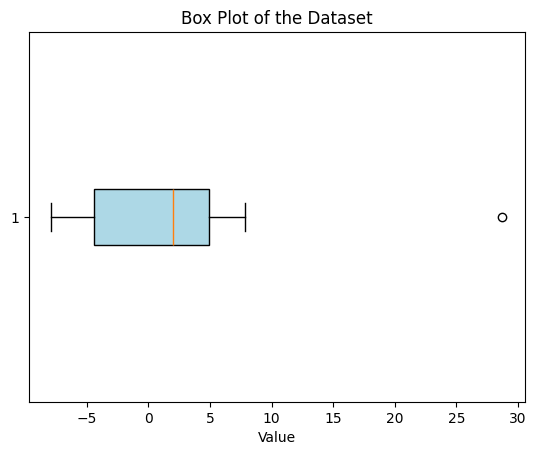

In [ ]:
import matplotlib.pyplot as plt

# Box plot
plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Box Plot of the Dataset")
plt.xlabel("Value")
plt.show()


b. Scatter Plot: - Create a scatter plot to visualize the distribution of the data points, and mark the outliers in a different colour or symbol.

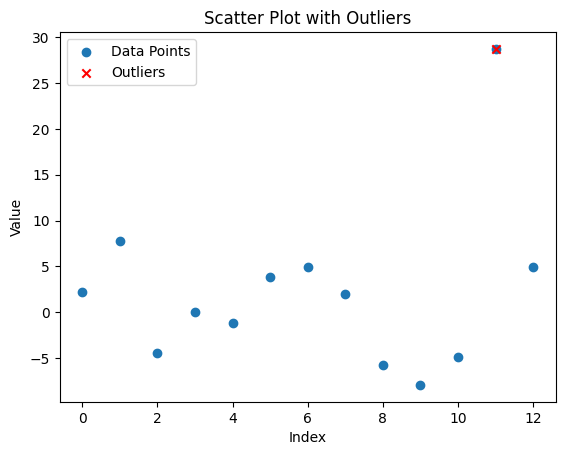

In [ ]:
# Scatter plot with outliers marked
plt.scatter(range(len(data)), data, label="Data Points")
plt.scatter([i for i, x in enumerate(data) if x in outliers],
            [x for x in data if x in outliers], color='red', label="Outliers", marker='x')
plt.title("Scatter Plot with Outliers")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()
